# COVID-19 : Exploratory Data Analysis and Exponential Modeling to Predicton of Cases in India

This notebook contains an exploratory data analysis of the growth of cases of COVID-19 in India, and trying to fit the growth model to an exponential growth curve.

The dataset comes from: https://github.com/covid19india/api/blob/master/data.json

Thanks to the work of Guillaume Raille for creation of the Growth Modeling API and laying a foundation to analysis of COVID-19 growth data in Switzerland. The original work can be found here: https://github.com/grll/covid19-cases-prediction

## Retrieve the data

In [1]:
# Imports

import csv
import json
import urllib.request
from datetime import datetime

In [2]:
# Define the URL

url = "https://raw.githubusercontent.com/covid19india/api/master/data.json"

In [4]:
# Write the data in a new CSV file named 'data.csv' and amend the format of dates
# Thanks to my great friend Sahil Gupte (https://github.com/Ovenoboyo) for helping me out with csv and json

with urllib.request.urlopen(url) as f:
    data = json.loads(f.read())['cases_time_series']
    writer = csv.writer(open('data.csv', 'w+'))
    writer.writerow(list(data[0].keys()))
    for items in data:
        write_list = []
        for key,value in items.items():
            if key == "date":
                d = datetime.strptime("2020 " + value, '%Y %d %B ')
                write_list.append(d.strftime("%Y-%m-%d"))
            else :
                write_list.append(value)
        writer.writerow(write_list)

## Exploratory Data Analysis

In [5]:
# Imports

from datetime import date, timedelta

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

%matplotlib inline

In [6]:
# Retrieve the cases from file

covid19_cases = pd.read_csv('data.csv', parse_dates=['date'], index_col='date')
covid19_cases.head()

,dailyconfirmed,dailydeceased,dailyrecovered,totalconfirmed,totaldeceased,totalrecovered
date,,,,,,
2020-01-30,1,0,0,1,0,0
2020-01-31,0,0,0,1,0,0
2020-02-01,0,0,0,1,0,0
2020-02-02,1,0,0,2,0,0
2020-02-03,1,0,0,3,0,0


In [7]:
# Check if the index is_unique

covid19_cases.index.is_unique

True

In [8]:
# Check the dimensionality of the data

covid19_cases.shape

(71, 6)

In [9]:
# Show basic statistics

covid19_cases.describe()

,dailyconfirmed,dailydeceased,dailyrecovered,totalconfirmed,totaldeceased,totalrecovered
count,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000
mean,94.774648,3.225352,8.943662,695.676056,19.535211,59.450704
std,191.665646,7.784962,20.148653,1508.590854,46.434849,132.504532
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,3.000000,0.000000,2.000000
50%,2.000000,0.000000,0.000000,30.000000,0.000000,3.000000
75%,73.500000,1.000000,4.000000,450.000000,8.000000,24.000000
max,813.000000,46.000000,96.000000,6729.000000,229.000000,635.000000


**The following observations can be made :**

- The dataset consists of various columns and the column 'totalconfirmed' is a cumulative count of confirmed cases
- The count is given per day, where each row corrosponds to a single day
- The data starts with the first assumed case on 2020-01-30 and continues till date

- **The data seemes to be increasing very slowly upto the 75th percentile, and rapidly thereafter; this increase should roughly correspond to the events related to the Tablighi Jamaat in New Delhi, which led to a sudden explosion in the number of cases all over the country**

### NOTE : We can expect that the sudden rise in numbers could lead to an uneven graph, which can then lead to inaccurate predctions

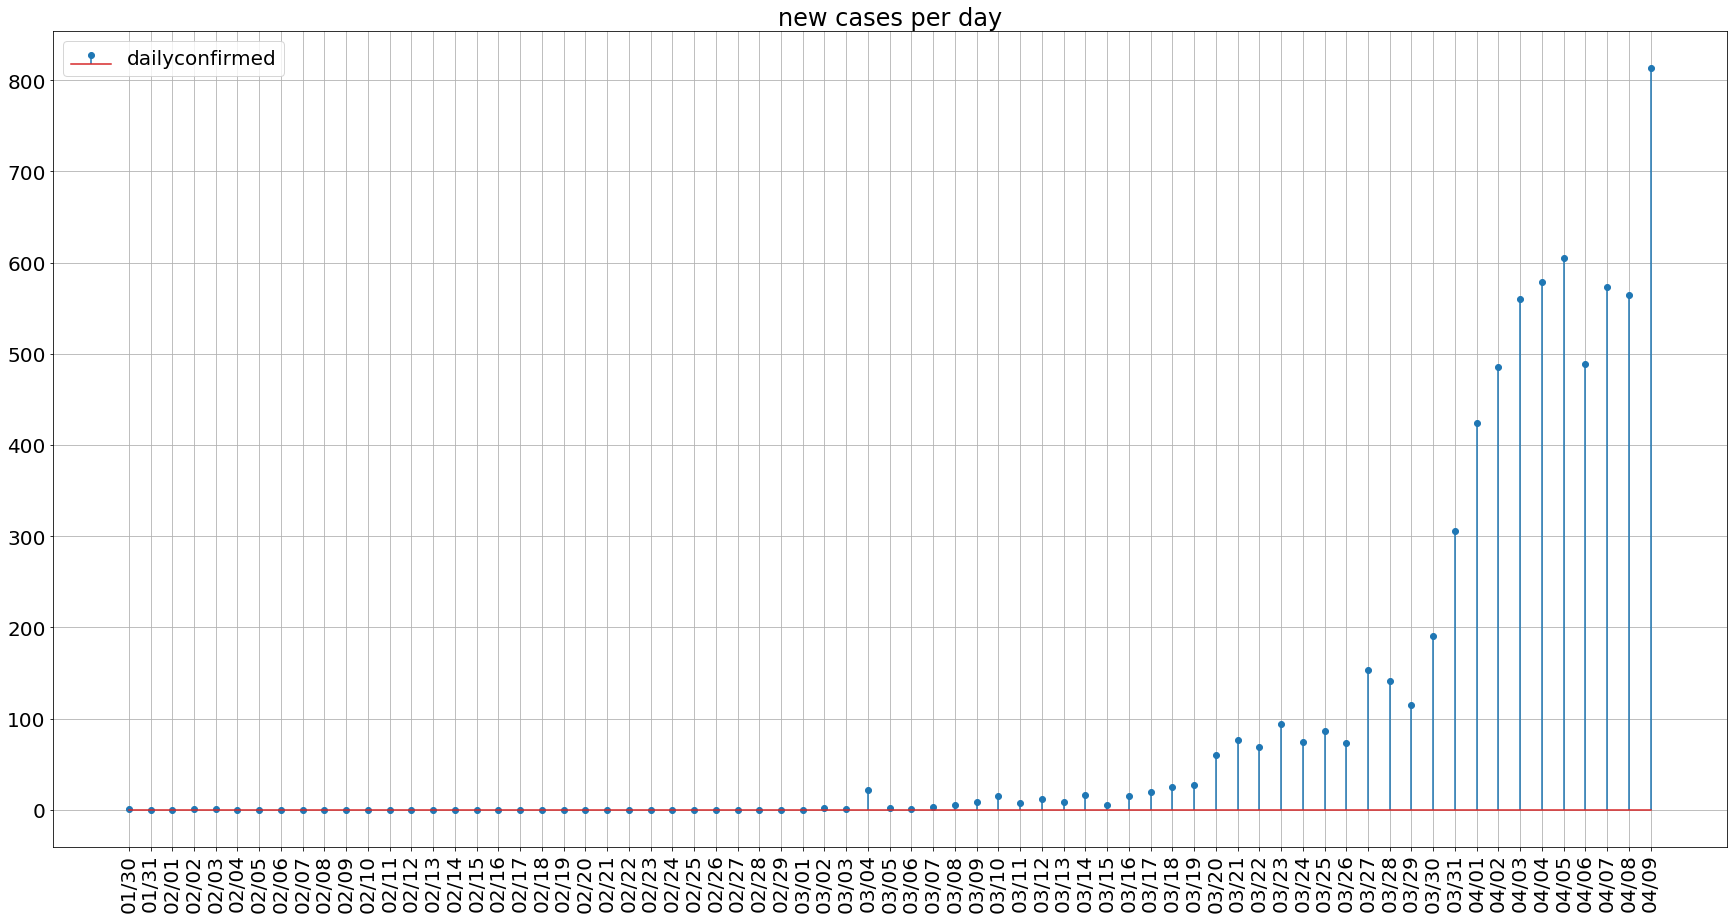

In [11]:
# Plot the daily cases as a histogram

fig = plt.figure(figsize=[30,15])
ax = plt.subplot(111)

ax.stem(covid19_cases.dailyconfirmed.index, covid19_cases.dailyconfirmed.values, label='dailyconfirmed', use_line_collection=True)

plt.title('new cases per day')
ax.legend()
plt.xticks(covid19_cases['dailyconfirmed'].index, rotation=90)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.grid(True)

plt.rc('font', size=20)

plt.show()

**The following obsetvations can be made :**

- The graph is almost asymptotic to the x-axis in linear scale upto around 60% of its span
- We can conclude that the major rise happened at around 60% of the span of this graph
- Due to this 'uneven' curve, any growth model can't be fit because it would be feeding on irrelevant data

### Let us now cut down our data to be from 01-03-2020, from where the actual significant increase began

In [13]:
# Write the data in a new CSV file named 'data_new.csv'
# We would only be considering the cases from 01-03-2020 onwards

with urllib.request.urlopen(url) as f:
    data = json.loads(f.read())['cases_time_series']
    writer = csv.writer(open('data_new.csv', 'w+'))
    writer.writerow(list(data[0].keys()))
    for i, items in enumerate(data):
        if i not in range(31):
            write_list = []
            for key,value in items.items():
                if key == "date":
                    d = datetime.strptime("2020 " + value, '%Y %d %B ')
                    write_list.append(d.strftime("%Y-%m-%d"))
                else :
                    write_list.append(value)
            writer.writerow(write_list)

In [14]:
# extract cases data from file
path = 'data_new.csv'
covid19_cases_new = pd.read_csv(path, parse_dates=['date'], index_col='date')

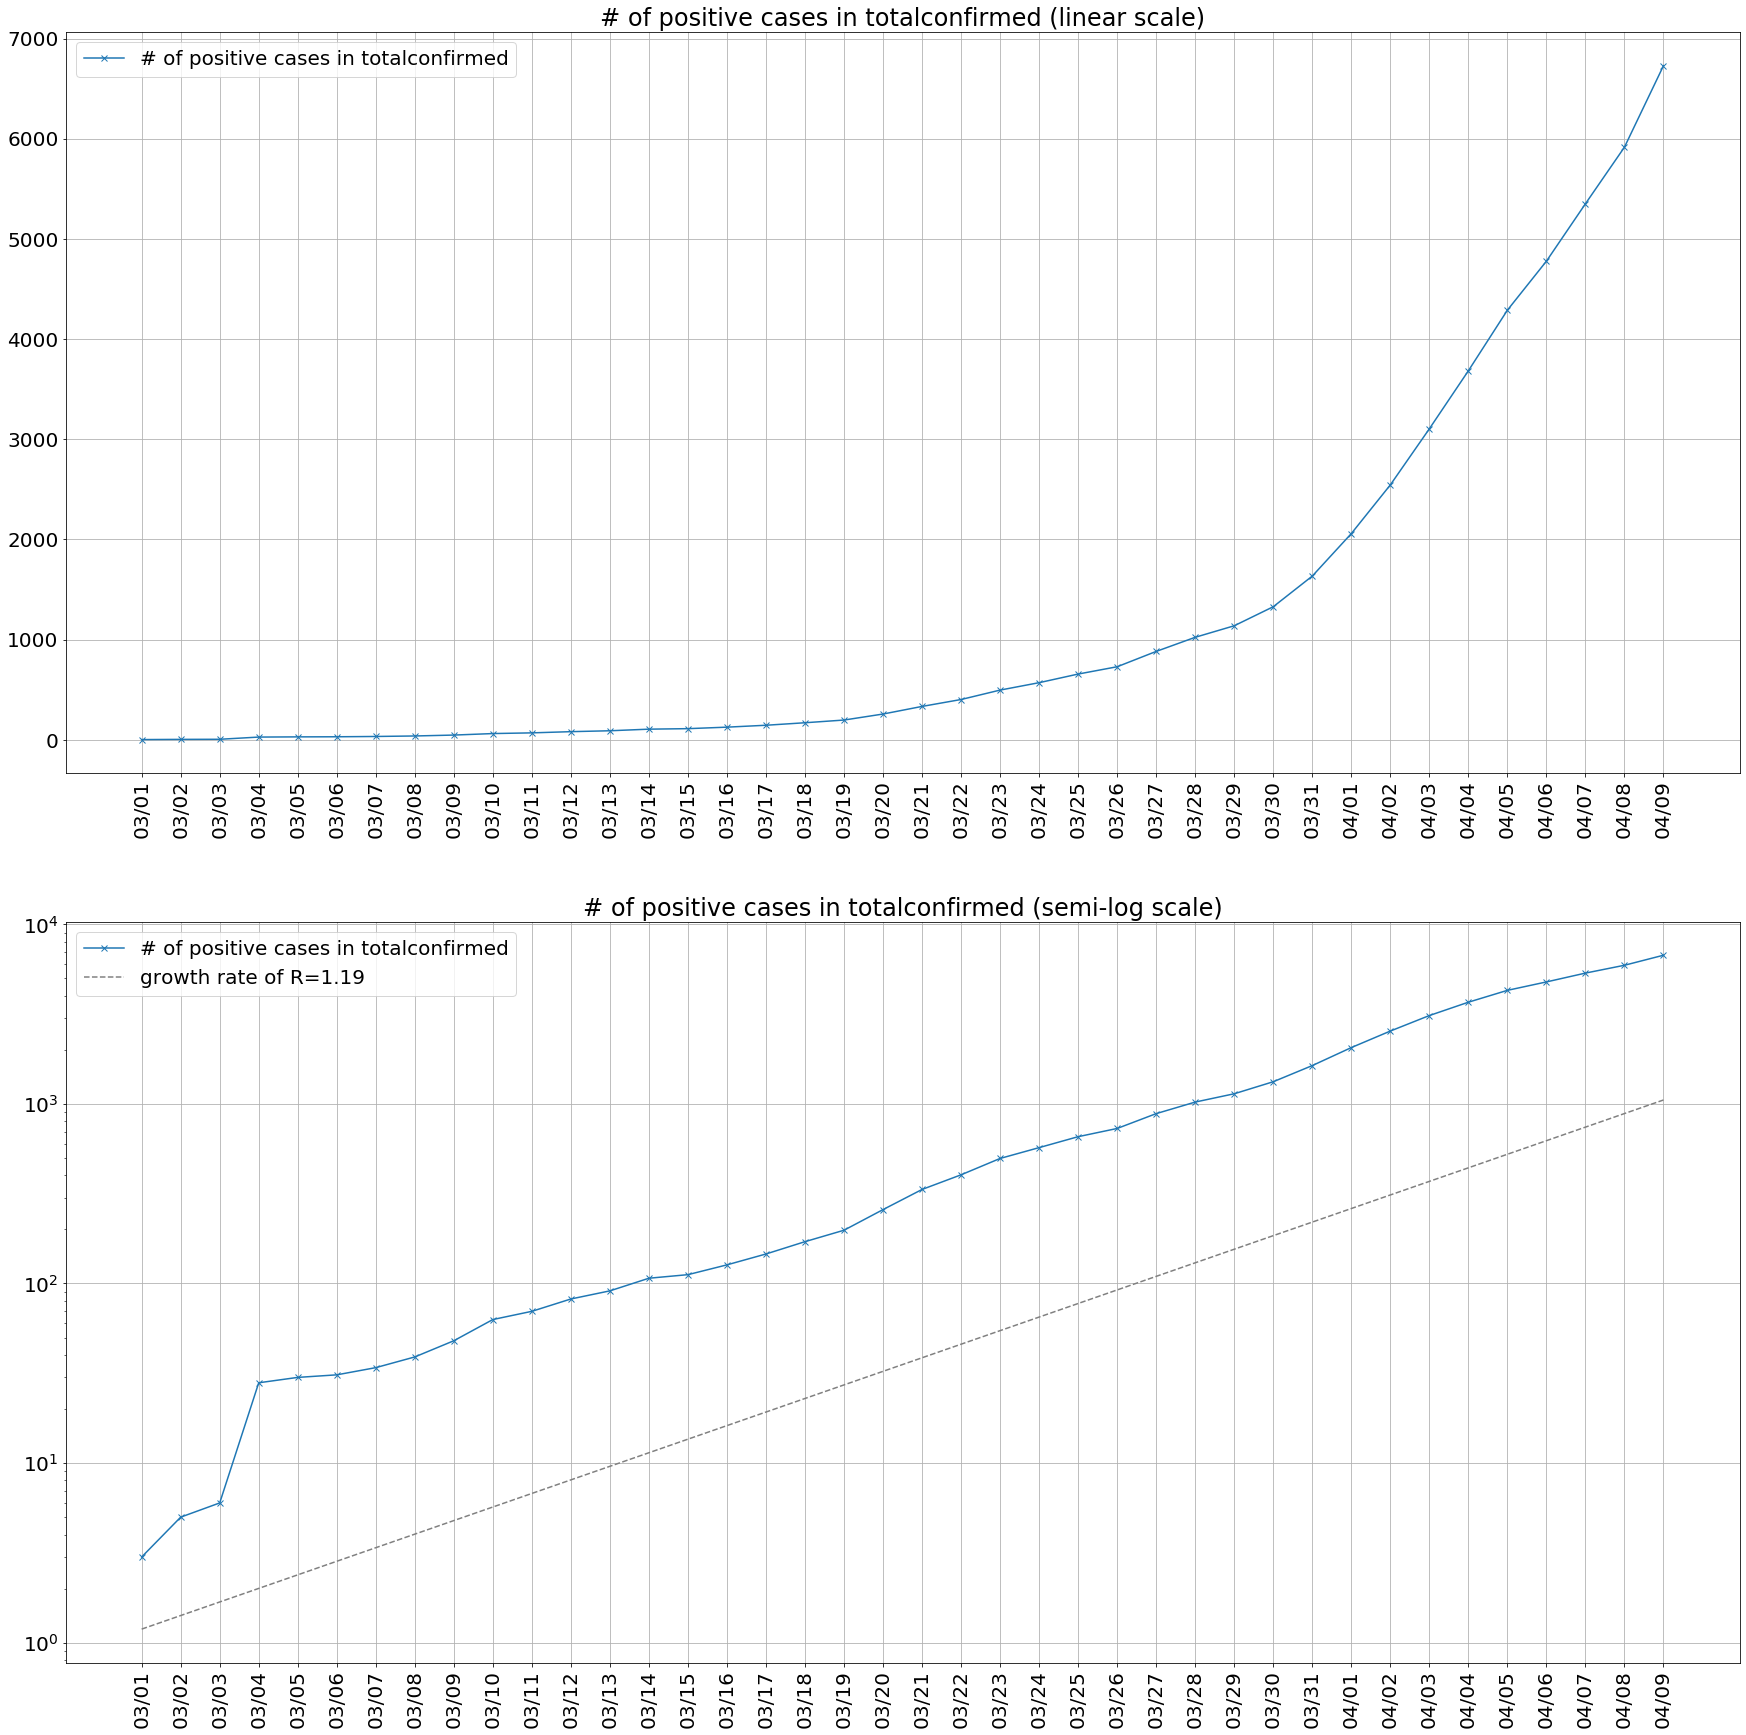

In [15]:
# Plot the cases on a linear and semi-logarithmic graph
data_conf = covid19_cases_new['totalconfirmed']

fig = plt.figure(figsize=[30,30])

ax = plt.subplot(211)
ax.plot(data_conf.index, data_conf.values, marker='x', label='# of positive cases in totalconfirmed')
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xticks(data_conf.index, rotation=90)
plt.title('# of positive cases in totalconfirmed (linear scale)')
plt.grid(True)


ax2 = plt.subplot(212)
ax2.semilogy(data_conf.index, data_conf.values, marker='x', label='# of positive cases in totalconfirmed')
ax2.semilogy(data_conf.index,[1.19 ** i for i in range(1,len(data_conf.index) + 1)], ls='--', c='grey', label='growth rate of R=1.19')
ax2.legend()
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xticks(data_conf.index, rotation=90)
plt.title('# of positive cases in totalconfirmed (semi-log scale)')
plt.grid(True)

plt.rc('font', size=20)
           
plt.show()

**The following observations can be made :"

- The trend seems to follow an exponential growth on the linear scale
- And thus, it follows a more or less 'linear' growth on the exponential scale

## Exponential Modeling Approach to Cases Prediction

In [16]:
# Imports

from datetime import timedelta
from math import sqrt

import pandas as pd
from scipy.stats import poisson
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.metrics import r2_score

# Import created Packages by github.com/grll

from growth_modeling import ExponentialGrowth
from growth_modeling import ExponentialGeneralizedGrowth

%matplotlib inline

In [17]:
# Dataframe with only the cumulative count of cases (totalconfirmed)
conf_df = covid19_cases_new[['totalconfirmed']].reset_index()
conf_df.rename({'totalconfirmed': 'cumulative_cases'}, axis=1, inplace=True)

# Create time column in days
starting_date = conf_df.date.iloc[0]
conf_df['t'] = conf_df.date.apply(lambda date: (date - starting_date).days)

# print head to visualise data
conf_df.head()

,date,cumulative_cases,t
0,2020-03-01,3,0
1,2020-03-02,5,1
2,2020-03-03,6,2
3,2020-03-04,28,3
4,2020-03-05,30,4


In [18]:
# Helper code 1, or some shit like that

def ax_growth_model(data, predictions, fit_up_to=0, subplot=111, asymptote=None):
    r"""create an matplotlib axes object to ease plotting growth models.
    
    Parameters
    ----------
    data : pd.Series
        a series with as values the observed cumulative number of cases and as index
        the time in days.
    predictions : array_like
        an array_like object containing predictions `pd.Series` made from a growth models
        **warning** the name of the series must be specified and a supplementary attribute
        `color` must be set.
    fit_up_to : int, optional
        the end slice to which the predictions model was fit to.
    subplot : int, optional
        argument passed to plt.subplot()
    asymptote : int, optional
        the asymptotic value of the growth model.
    
    Returns
    -------
    ax : pyplot.Axes
        an axes object with the correspondings plots.
    """
    ax = plt.subplot(subplot)
    
    days_to_date = lambda x: x.map(lambda item: conf_df.iloc[0].date + timedelta(days=item)).values
    
    if fit_up_to != 0:
        data_fit = data[:fit_up_to]
        data_after_fit = data[fit_up_to:]
    else:
        data_fit = data
        data_after_fit = None
    
    ax.scatter(days_to_date(data_fit.index), data_fit.values, label="data used to fit model", color="r", marker='x')
    if data_after_fit is not None:
        ax.scatter(days_to_date(data_after_fit.index), data_after_fit.values, label="data not used to fit model", color="grey", marker='x')
    
    dates_for_axis = conf_df.date.values
    for serie in predictions:
        d = days_to_date(serie.index)
        if max(d) > max(dates_for_axis):
            dates_for_axis = d
        ax.plot(days_to_date(serie.index), serie.values, label=serie.name, color=serie.color)
        
     
    if asymptote is not None:
        ax.hlines(asymptote, dates_for_axis[0], dates_for_axis[-1], color="grey", linestyle="--", label="aymptotic value")
    
    ax.legend()
    ax.set_xlabel('date (month/day)')
    ax.set_ylabel('Cumulative Number of Confirmed Cases')
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    plt.xticks(dates_for_axis, rotation=90)
    days_to_date(serie.index)
    ax.set_xlim((dates_for_axis[0], dates_for_axis[-1]))
    ax.set_ylim((0, 7000))
    ax.grid(True)

    return ax

In [19]:
# Helper code 2, or some shit like that

def fit_growth_model(GrowthModel, params, bounds, t, y, name, color, fit_up_to=0, predict_up_to=0):
    r"""Fit a provided GrowthModel and return predicted values series.
    
    Parameters
    ----------
    GrowthModel : Growth
        one the Growth class implemented in growth_modeling.
    params : dict
        a dict of params to initialize the model with
    bounds : array_like
        bounded for each of the parameter (specified similarly as in scipy.optimize.curve_fit)
    t : array_like
        time values to fit the growth model on.
    y : array_like
        response values to fit the growth model on.
    name: str
        name of the model to fit.
    color: str
        a matplotlib color to put as attribute of the serie.
    fit_up_to : int, optional
        the end slice to which the predictions model was fit to.
    predict_up_to : int, optional
        the number of days to predict up to.
    """
    growth = GrowthModel(params.copy(), bounds)
    growth.y_0 = y[0]
    
    # -- FULL DATASET
    growth.fit(t, y)
    print("[OPTIMISED params (full dataset)]")
    print(growth.params)
    
    y_pred = growth.compute_y(t)
    print("R2 SCORE (full dataset): {}".format(r2_score(y, y_pred)))
    
    t_predict = np.array(range(predict_up_to)) if predict_up_to != 0 else t
    growth_serie = pd.Series(growth.compute_y(t_predict), name=name)
    growth_serie.color = color
    
    # -- REDUCED DATASET
    if fit_up_to != 0:
        growth.params = params.copy()
        growth.fit(t[:fit_up_to], y[:fit_up_to])
        print("\n[OPTIMISED params (dataset[:{}])]".format(fit_up_to))
        print(growth.params)
    
        y_pred = growth.compute_y(t)
        print("R2 SCORE (full dataset): {}".format(r2_score(y, y_pred)))
        
        y_pred = growth.compute_y(t[:fit_up_to])
        print("R2 SCORE (training dataset): {}".format(r2_score(y[:fit_up_to], y_pred)))
        
        y_pred = growth.compute_y(t[fit_up_to:])
        print("R2 SCORE (testing dataset): {}".format(r2_score(y[fit_up_to:], y_pred)))
    
        growth_serie_lim = pd.Series(growth.compute_y(t_predict), name=name)
        growth_serie_lim.color = color
        
        return (growth_serie, growth_serie_lim)
    
    return (growth_serie,)

### 1. Fitting Exponential Growth

**Simple Exponential Model** can be written as :

$\frac{\partial y}{\partial t} = ay \Leftrightarrow y = y_0 e^{at}$

where :

- $y$ is the observed response (number of cumulative cases)
- $t$ is time step (in days)
- $a$ is the growth rate (relative derivative increase compared to the number of total cases)
- $y_0$ is the observed response at t=0

**Generalised Exponential Model** can be written as :

$\frac{\partial y}{\partial t} = ay^p \Leftrightarrow y = [(1 - p)at + y_0^{1-p}]^{\frac{1}{1-p}}$

where all the parameters are identical and :

- $p$ is a parameter allowing sub-exponential regime ($0<p<1$)

This 2 models are now fitted to the whole dataset using non-linear least square optimisation to find the optimal parameters :

- for the simple case: $a = \arg\min_{a} \sum_{i=0}^{i=k}{(y_i - y_{exp})^2}$
- for the generalized case: $a, p = \arg\min_{a,p} \sum_{i=0}^{i=k}{(y_i - y_{exp})^2}$

where :

- $k$ is the number of values in the dataset
- $y_i$ is the real response value from the dataset
- $y_{exp}$ is the predicted value from the model using the closed-form solution above for $y$

In [20]:
t = conf_df.t.values
y = conf_df.cumulative_cases.values
fit_up_to = -5

# fit normal exponential
params = {"a": 0.2}
bounds = (0.0, 10.0)
exponential_predictions = fit_growth_model(ExponentialGrowth, params, bounds, t, y, "exponential growth", 'y', fit_up_to=fit_up_to)

print("")

# fit generalized exponential
params = {"a": 0.2, "p": 0.5}
bounds = (0.0, (10.0, 1.0))
exponential_generalized_predictions = fit_growth_model(ExponentialGeneralizedGrowth, params, bounds, t, y, "generalized exponential growth", 'g', fit_up_to=fit_up_to)

[OPTIMISED params (full dataset)]
{'a': 0.2017137004475822}
R2 SCORE (full dataset): 0.9610057021006266

[OPTIMISED params (dataset[:-5])]
{'a': 0.21038853388597475}
R2 SCORE (full dataset): 0.759078614156992
R2 SCORE (training dataset): 0.9899830732167241
R2 SCORE (testing dataset): -7.678286445353244

[OPTIMISED params (full dataset)]
{'a': 0.33828419444788993, 'p': 0.8982132912995909}
R2 SCORE (full dataset): 0.9958887679025503

[OPTIMISED params (dataset[:-5])]
{'a': 0.26234453449775985, 'p': 0.9519118279182713}
R2 SCORE (full dataset): 0.9521203305827983
R2 SCORE (training dataset): 0.9959182552637195
R2 SCORE (testing dataset): -0.7078683473793317


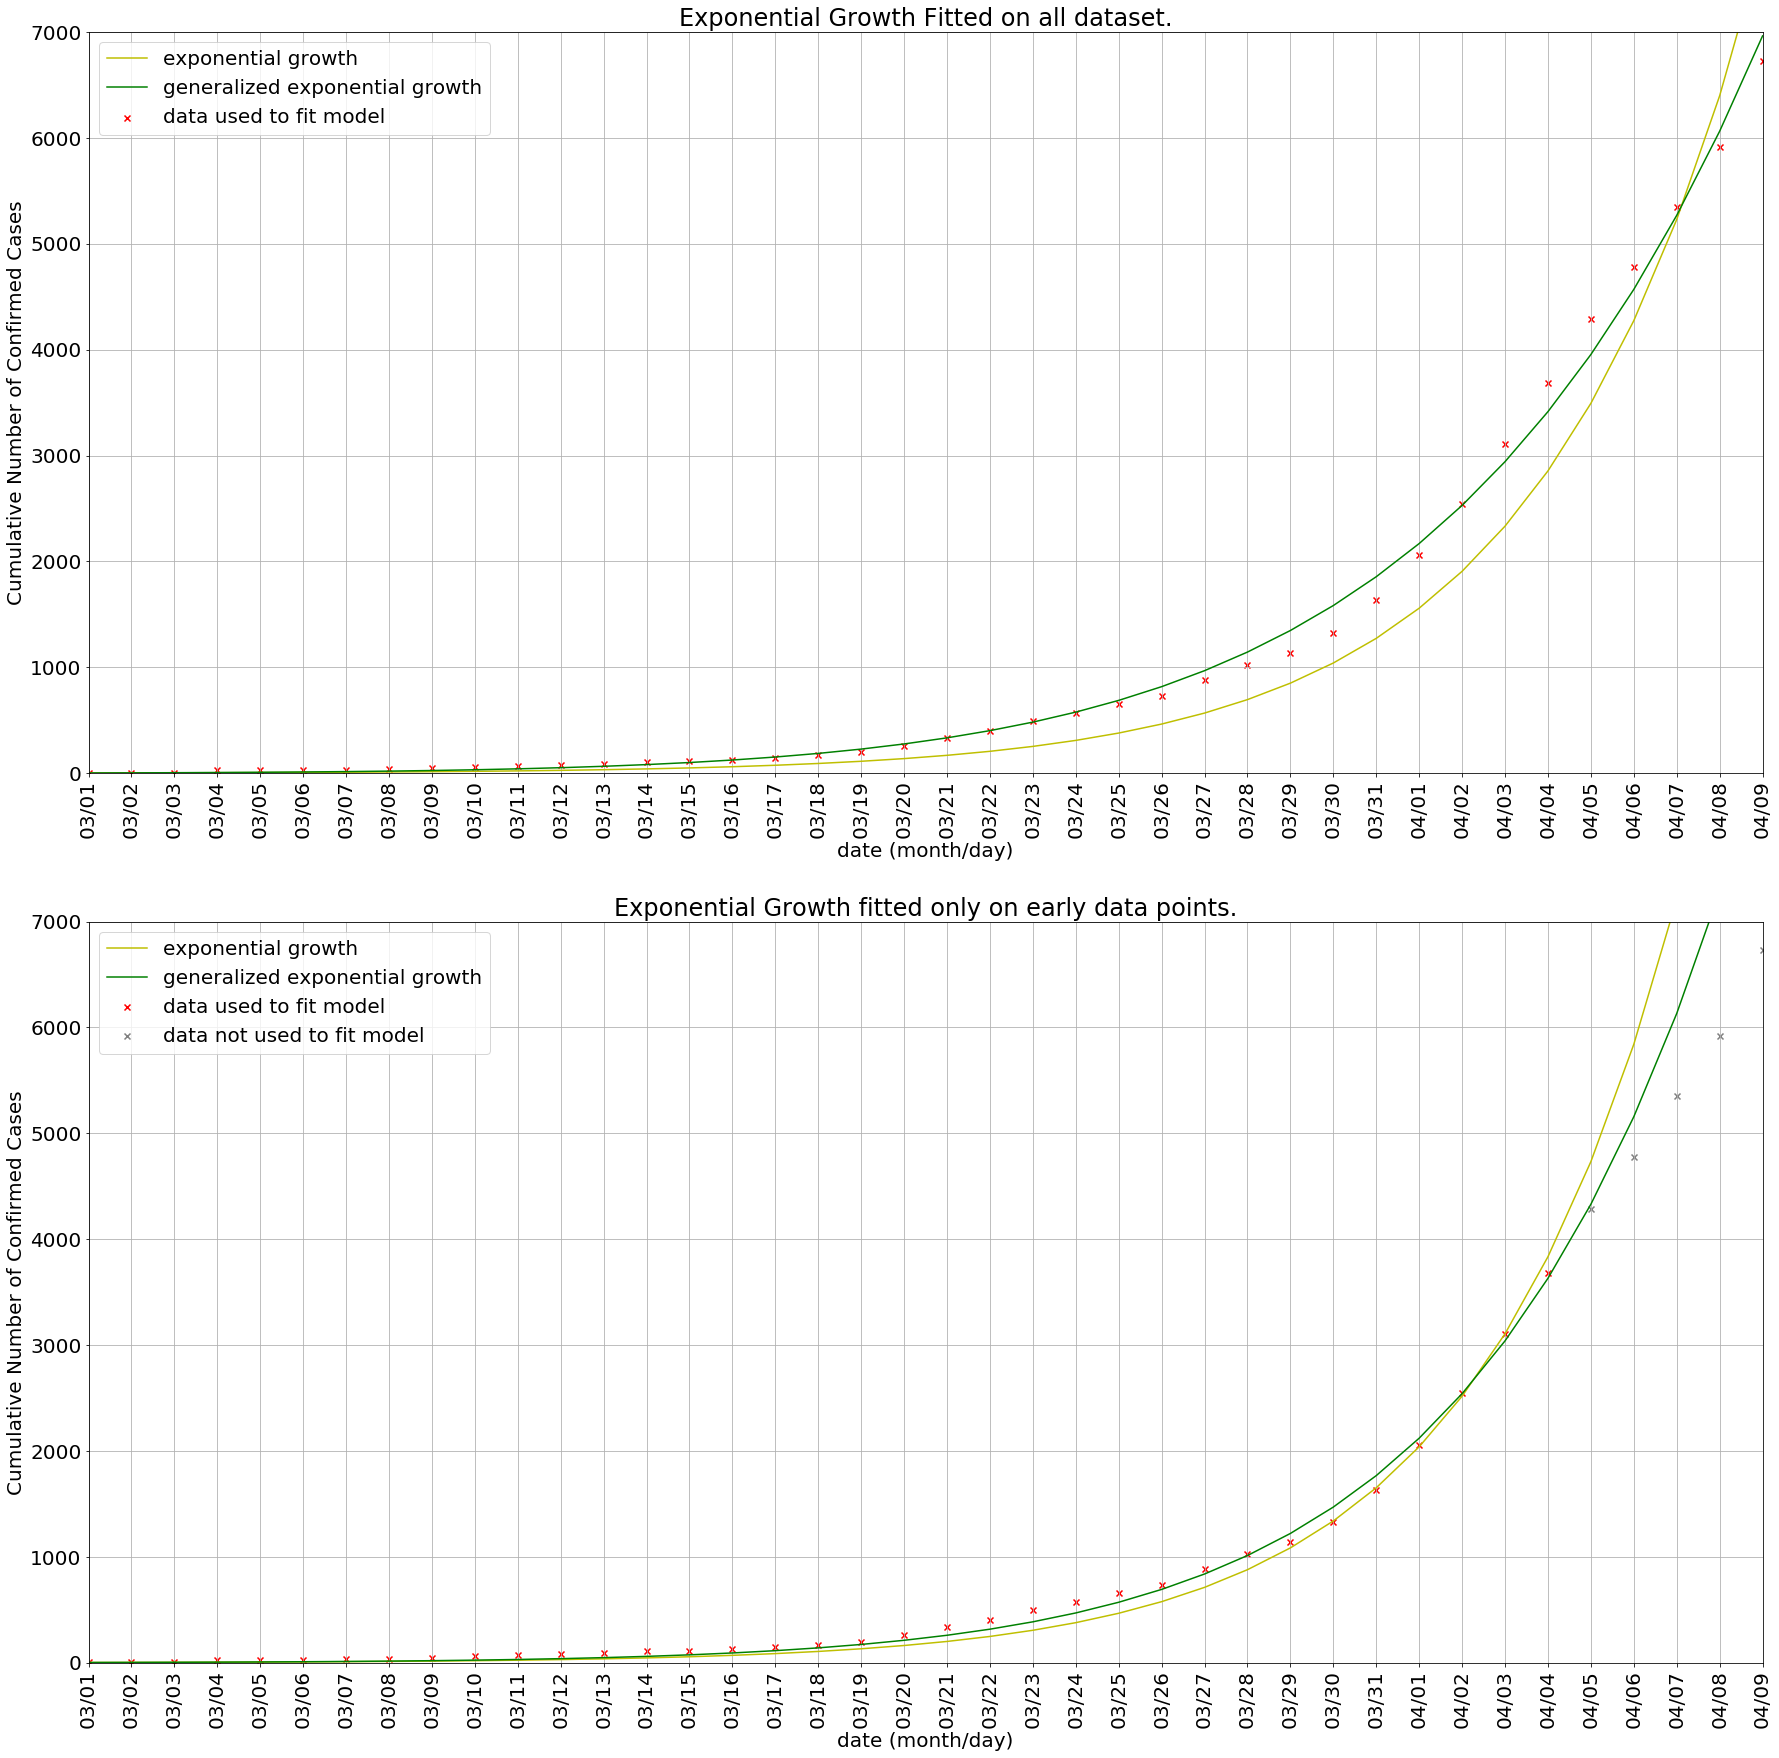

In [22]:
# plot the results
plt.figure(figsize=[30,30])

ax = ax_growth_model(conf_df.cumulative_cases, (exponential_predictions[0], exponential_generalized_predictions[0]), subplot=211)
ax.set_title('Exponential Growth Fitted on all dataset.')

ax = ax_growth_model(conf_df.cumulative_cases, (exponential_predictions[1], exponential_generalized_predictions[1]), fit_up_to=fit_up_to, subplot=212)
ax.set_title('Exponential Growth fitted only on early data points.')

plt.rc('font', size=20)

plt.show()

**The following observations can be made :**

- When the full data is used to fit the models, the generalised exponential growth seems to better fit the data
- When fitted on only the first part of the data, both models seem to fail to accurately predict the growth

**Conclusion :**

- The inability of the models to predict the growth on behalf of early data points indicate **a fall in the rate of growth** of this pandemic
- Logistic models may do better than exponential models in the days that are yet to come

## ...to be continued, subject to the availability of data in the days to come